# Introduction



# Data

#### Import and mounting drive to get data
In the following cells, we are installing the necessary libraries and google drive locations in order for the Colab notebook to run

The link for the "Project" folder is:
https://drive.google.com/drive/folders/1eICx4_qy4Rvi7TsA3dCrkCYceuvLrDAC?usp=sharing

In [ ]:
!pip install transformers
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-linux_x86_64.whl size=4395572 sha256=a8e156b4ee9aae8363101667d57423a615cfda2a163e16c0d67dff2f4ddc4001
  Stored in directory: /root/.cache/pip/wheels/64/57/bc/1741406019061d5664914b070bd3e71f6244648732bc96109e
Successfully built fasttext


In order for the Colab to function as expected, please add the "Project" folder to "MyDrive" in Google Drive as the following path: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Classes/CMPT713/Project

Mounted at /content/drive
/content/drive/MyDrive/Classes/CMPT713/Project


In [ ]:

import json
import logging
import os
import random
import re
from collections import Counter, OrderedDict, defaultdict
from datetime import datetime
from string import punctuation

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn import preprocessing
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader,TensorDataset
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from transformers import AdamW, AutoModel, AutoTokenizer, RobertaModel, BertModel, BertConfig, AutoModelForSequenceClassification
from nltk.corpus import stopwords
import nltk
import fasttext
from sklearn.metrics import precision_recall_curve

import warnings
warnings.filterwarnings("ignore")
# here we are just arbitrarily using this model path for demo in this project.ipynb only.
model_path = "model_path_for_demo"
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]
%matplotlib inline

logging.basicConfig(
    level=logging.INFO,
    filename="bert_bilstm.log",
    filemode="w",
    format="%(asctime)s - %(message)s",
)
writer = SummaryWriter(log_dir=model_path)
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

Setting seed for random

In [ ]:
SEED = 9999
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Preparation Step for BERT: initializing tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

#### Getting Data

In [ ]:

# initialize
texts = []
labels = []

# reading data from gossipcop and politifact data sources
data = pd.read_csv("data/gossipcop_real.csv")
texts.extend(data["title"])
labels.extend(["real"] * len(data))

data = pd.read_csv("data/gossipcop_fake.csv")
texts.extend(list(data["title"]) * 3)
labels.extend(["fake"] * len(data) * 3)

data = pd.read_csv("data/politifact_fake.csv")
texts.extend(list(data["title"]) * 3)
labels.extend(["fake"] * len(data) * 3)

data = pd.read_csv("data/politifact_real.csv")
texts.extend(data["title"])
labels.extend(["real"] * len(data))


# reading data from NewsDataset folders
def read_data(path, label):
    texts = []
    labels = []
    for root, dirs, files in os.walk(path, topdown=True):
        for file_name in tqdm(files):
            if not file_name.endswith("txt"):
                continue
            texts.append(
                open(os.path.join(root, file_name), "r", encoding="utf-8").read()
            )
            labels.append(label)
    return texts, labels

    tmp_texts, tmp_labels = read_data("data/NewsDataset-1/fake/", "fake")


tmp_texts, tmp_labels = read_data("data/NewsDataset-1/legit/", "real")
texts.extend(tmp_texts)
labels.extend(tmp_labels)

tmp_texts, tmp_labels = read_data("data/NewsDataset-2/fake/", "fake")
texts.extend(tmp_texts * 3)
labels.extend(tmp_labels * 3)

tmp_texts, tmp_labels = read_data("data/NewsDataset-2/legit/", "real")
texts.extend(tmp_texts)
labels.extend(tmp_labels)


len(texts), Counter(labels)

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

(35946, Counter({'real': 17931, 'fake': 18015}))

#### Exploratory Data Analysis

Distribution of real news vs fake news

<BarContainer object of 2 artists>

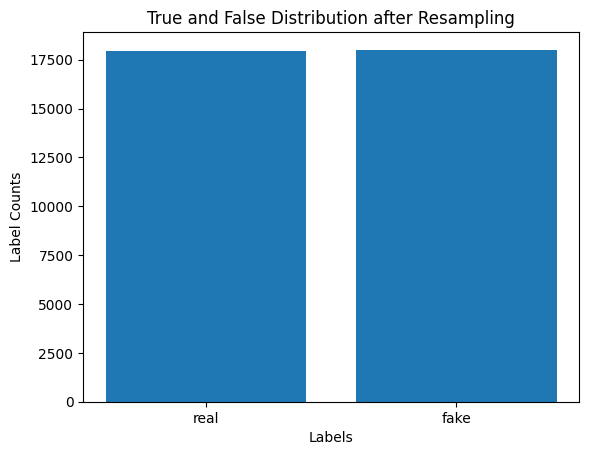

In [ ]:
# Inspired by the official documentation from Matplotlib
plt.style.use('default')

label_names = list(Counter(labels).keys())
label_counts = list(Counter(labels).values())


plt.xlabel("Labels")
plt.ylabel("Label Counts")
plt.title("True and False Distribution after Resampling")

plt.bar(label_names, label_counts)

In [ ]:
# merge df
df = pd.DataFrame({'texts': texts,'labels': labels})
# print df shape
print("Dataframe Shape is: {}".format(df.shape))
# no missing values
print("No Null Values for Columns:")
print(df.isnull().sum())


display(df.head())

Dataframe Shape is: (35946, 2)
No Null Values for Columns:
texts     0
labels    0
dtype: int64


,texts,labels
0,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,real
1,Kylie Jenner refusing to discuss Tyga on Life ...,real
2,Quinn Perkins,real
3,I Tried Kim Kardashian's Butt Workout & Am For...,real
4,Celine Dion donates concert proceeds to Vegas ...,real


we can see that the proportions of real news vs fake news differ significantly for different celebrities:


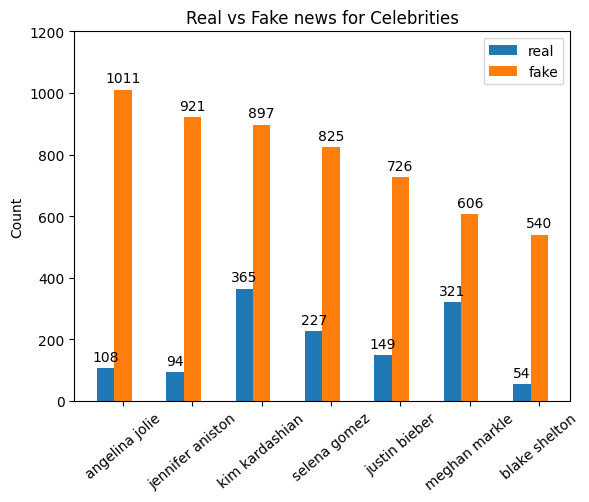

In [ ]:
df['texts'] = df['texts'].str.lower()
real = df.loc[df['labels'] == 'real']
fake = df.loc[df['labels'] == 'fake']

celebrity_names = ['angelina jolie','jennifer aniston', 'kim kardashian', 
                   'selena gomez','justin bieber', 'meghan markle',  'blake shelton']

real_count = []
fake_count = []

for name in celebrity_names:
    real_count.append(real.texts.str.count(name).sum())
    fake_count.append(fake.texts.str.count(name).sum())

print("we can see that the proportions of real news vs fake news differ significantly for different celebrities:")


# Adapted from official documentation of matplotlib:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

news = {
    'real': real_count,
    'fake': fake_count
}

x = np.arange(len(celebrity_names))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()#layout='constrained')

for category, count in news.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, count, width, label=category)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for the graph such as labels, title
ax.set_ylabel('Count')
ax.set_title('Real vs Fake news for Celebrities')
ax.set_xticks(x + width)
ax.set_xticklabels(celebrity_names, rotation=40)
ax.legend(loc='upper right')
ax.set_ylim(0, 1200)

plt.show()


# Approach

## FastText Preprocessing

First, we need to remove punctuations for the texts in FastText embedding, and then build an embedding matrix based on our words in the FastText

In [ ]:
def train_fasttext_embeddings(texts):
    if os.path.exists("fasttext.bin"):
        fasttext_model = fasttext.load_model(os.path.abspath("fasttext.bin"))
    else:
        with open(".temp", "w", encoding="utf-8") as f:
            for i in texts:
                f.write(f"{i}\n")
        fasttext_model = fasttext.train_unsupervised(".temp", dim=768, minCount=1)
        fasttext_model.save_model("fasttext.bin")

    vocab_list = list(fasttext_model.words)

    embeddings_matrix = np.zeros((len(vocab_list) + 1, fasttext_model.get_dimension()))
    for i in range(len(vocab_list)):
        word = vocab_list[i]
        embeddings_matrix[i] = fasttext_model.get_word_vector(word)

    vocab_size = len(vocab_list) + 1

    return fasttext_model, embeddings_matrix, vocab_size

fasttext_model, embeddings_matrix, vocab_size = train_fasttext_embeddings(texts)


Here we are splitting the data into training, validation, and testing sets

In [ ]:
def split_data(texts, labels):
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        texts, labels, stratify=labels, test_size=0.2, random_state=43)

    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_texts,train_labels, stratify=train_labels, test_size=0.25, random_state=43)
    
    return train_texts, val_texts, test_texts, train_labels, val_labels, test_labels

train_texts, val_texts, test_texts, train_labels, val_labels, test_labels = split_data(texts, labels)

Then we preorocess the data to first remove punctuations and then convert the texts into embedded matrix form

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))

def preprocess_data(texts):
    cleaned_texts = texts.copy()
    punctuation_added = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”？，！【】（）、。：；’‘……￥·"""
    dicts = {i: "" for i in punctuation + punctuation_added}
    punc_table = str.maketrans(dicts)

    stop_words = set(stopwords.words("english"))
    
    for idx, i in tqdm(enumerate(cleaned_texts), total=len(cleaned_texts)):
        tmp = []
        seg = nltk.word_tokenize(i)
        for item in seg:
            word = item.strip()
            if not word:
                continue
            if len(word) < 2:
                continue
            word = word.translate(punc_table)
            word = word.strip()
            if not word:
                continue
            if word in stop_words:
                continue
            tmp.append(word)
        cleaned_texts[idx] = " ".join(tmp)
    return cleaned_texts


def text_to_sequence(texts, labels, fasttext_model, vocab_size,  maxlen=128):
    X = [
        [
            fasttext_model.get_word_id(word) if fasttext_model.get_word_id(word) != -1 else vocab_size - 1
            for word in text.split()
        ][:maxlen] + [vocab_size - 1] * (maxlen - len(text.split()))
        for text in texts
    ]
    X = np.array(X)
    # label_id = {item: idx for idx, item in enumerate(sorted(set(labels)))}
    label_id = {'fake': 1, 'real': 0}
    y = np.asarray([label_id[label] for label in labels])

    return X, y

X_train, y_train = text_to_sequence(preprocess_data(train_texts), train_labels, fasttext_model, vocab_size)
X_val, y_val =  text_to_sequence(preprocess_data(val_texts), val_labels, fasttext_model, vocab_size)
X_test, y_test = text_to_sequence(preprocess_data(test_texts), test_labels, fasttext_model, vocab_size)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  0%|          | 0/21567 [00:00<?, ?it/s]

  0%|          | 0/7189 [00:00<?, ?it/s]

  0%|          | 0/7190 [00:00<?, ?it/s]

In [ ]:
del fasttext_model

#### Dataloader

Feeding the training, validation, and testing data into their respective dataloader

In [ ]:


def prepare_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    X_train = torch.from_numpy(X_train)
    X_val = torch.from_numpy(X_val)
    X_test = torch.from_numpy(X_test)
    y_train = torch.as_tensor(y_train, dtype=torch.int64)
    y_val = torch.as_tensor(y_val, dtype=torch.int64)
    y_test = torch.as_tensor(y_test, dtype=torch.int64)

    train_data = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=False)

    valid_data = TensorDataset(X_val, y_val)
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size)

    test_data = TensorDataset(X_test, y_test)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    return train_dataloader, valid_dataloader, test_dataloader

train_dataloader, valid_dataloader, test_dataloader = prepare_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test)





In [ ]:
embeddings_matrix.shape

(62694, 768)

## Fasttext + LSTM

define LSTM layer

In [ ]:
class LSTM(nn.Module):
    def __init__(
        self, embed_size, hidden_size, num_labels, inner_size, num_layers=1, dropout=0.2
    ):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers,
            bidirectional=False,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_size, inner_size)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(inner_size, num_labels)

    def forward(self, x):
        output, (last_hidden, _) = self.lstm(x)
        output = self.fc(output)
        output = self.activation(output)
        output = self.dropout(output)
        logits = self.classifier(output)
        return logits

define the model with FastText embedding and LSTM classification layer

In [ ]:
class Model(nn.Module):
    def __init__(
        self,
        embeddings_matrix,
        num_labels,
        embed_size,
        hidden_size,
        num_layers=1,
        dropout=0.1,
    ):
        super(Model, self).__init__()
        self.num_labels = num_labels
        self.embedding = nn.Embedding.from_pretrained(embeddings_matrix, freeze=False)
        self.lstm = LSTM(
            embed_size=embed_size,
            hidden_size=hidden_size,
            num_labels=num_labels,
            inner_size=4 * hidden_size,
            num_layers=num_layers,
            dropout=dropout,
        )

    def forward(self, x, labels=None):
        out = self.embedding(x)  # [batch_size, seq_len, embeding]
        logits = self.lstm(out)[:, -1, :]
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return loss, logits

Initialize the model

In [ ]:
model = Model(
    torch.from_numpy(embeddings_matrix).float(),
    embed_size=768,
    hidden_size=768,
    num_labels=2,
)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.train()

## FastText+BiLSTM

Define the BiLSTM layer

In [ ]:

class BiLSTM(nn.Module):
    def __init__(
        self, embed_size, hidden_size, num_labels, inner_size, num_layers=1, dropout=0.2
    ):
        super(BiLSTM, self).__init__()
        self.bilstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_size * 2, inner_size)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(inner_size, num_labels)

    def forward(self, x):
        output, (last_hidden, _) = self.bilstm(x)
        output = torch.cat(
            (
                last_hidden[ -1, :, :,],
                last_hidden[-2, :, :, ],
            ),
            axis=1,
        )
        output = self.fc(output)
        output = self.activation(output)
        output = self.dropout(output)
        logits = self.classifier(output)
        return logits


define the model with FastText and BiLSTM

In [ ]:
class Model(nn.Module):
    def __init__(self, embeddings_matrix, num_labels, embed_size, hidden_size,num_layers=1,dropout=0.2):
        super(Model, self).__init__()
        self.num_labels = num_labels
        self.embedding = nn.Embedding.from_pretrained(embeddings_matrix, freeze=False)
        self.bilstm = BiLSTM(
            embed_size=embed_size,
            hidden_size=hidden_size,
            num_labels=num_labels,
            inner_size=4 * hidden_size,
            num_layers=num_layers,
            dropout=dropout,
        )

    def forward(self, x, labels=None):
        out = self.embedding(x)  # [batch_size, seq_len, embeding]
        logits = self.bilstm(out)
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return loss, logits





define the model

In [ ]:
model = Model(
    torch.from_numpy(embeddings_matrix).float(),
    embed_size=768,
    hidden_size=768,
    num_labels=2,
)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Model(
  (embedding): Embedding(62694, 768)
  (bilstm): BiLSTM(
    (bilstm): LSTM(768, 768, batch_first=True, dropout=0.2, bidirectional=True)
    (fc): Linear(in_features=1536, out_features=3072, bias=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
    (classifier): Linear(in_features=3072, out_features=2, bias=True)
  )
)

## FastText+CNN

Define the CNN Layer, we add a CNN classifier on top of the FastText embedding (using the data from FastText preprocssing).

In [ ]:
class CNN_FOR_ALL_STATES(nn.Module):

    def __init__(self,embed_size, hidden_size, num_labels, num_layers=128, dropout=0.2):
        super(CNN_FOR_ALL_STATES, self).__init__()

        self.conv = nn.Conv2d(in_channels=1
        , out_channels=num_layers, kernel_size=(3, embed_size), padding=1)

        # self.conv = nn.Conv1d(in_channels=1, out_channels=num_layers, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1)
        # self.pool = nn.MaxPool1d(kernel_size=3, stride=1)
        self.dropout = nn.Dropout(dropout)
        # CHANGE: changed from 442x3
        self.fc = nn.Linear(16128, 2)
        self.flat = nn.Flatten()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(self.dropout(self.relu(self.conv(self.dropout(x)))))
        x = self.fc(self.dropout(self.flat(self.dropout(x))))
        return self.softmax(x)

Define the Model which consists of CNN layer and its FastText embedding, which is the embedding_matrix in our case

In [ ]:
class Model(nn.Module):
    def __init__(self,embeddings_matrix, embed_size, hidden_size, num_labels = 2, num_layers=13, dropout=0.2):
        super(Model, self).__init__()
        self.num_labels = num_labels
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_labels = num_labels
        self.num_layers = num_layers
        self.dropout = dropout
        self.cnn = CNN_FOR_ALL_STATES(embed_size, hidden_size, num_labels, num_layers, dropout)
        self.embedding = nn.Embedding.from_pretrained(embeddings_matrix, freeze=False)

    def forward(self, x, labels=None):
        out = self.embedding(x)
        out = out.unsqueeze(1)
        softmax = self.cnn(out)
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(softmax.view(-1, self.num_labels), labels.view(-1))
        return loss, softmax

In [ ]:
model = Model(
    embeddings_matrix = torch.from_numpy(embeddings_matrix).float(),
    embed_size=768,
    hidden_size=768,
    num_labels=2,
    num_layers=128, 
    dropout=0.2
)
device = (
    torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
) 
model.to(device)
model.train()

Model(
  (cnn): CNN_FOR_ALL_STATES(
    (conv): Conv2d(1, 128, kernel_size=(3, 768), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.2, inplace=False)
    (fc): Linear(in_features=16128, out_features=2, bias=True)
    (flat): Flatten(start_dim=1, end_dim=-1)
    (softmax): LogSoftmax(dim=1)
  )
  (embedding): Embedding(62694, 768)
)

## BERT Preprocessing

#### After getting the data, (for BERT based models) we need to preprocess the data to:

(1) split the data into training, validation, and testing set

(2) encode the texts using tokenizer

(3) load the encoded texts and their respective labels into training, validation, and testing dataloaders

#### Split Data

In [ ]:
def split_data(texts, labels):
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        texts, labels, stratify=labels, test_size=0.2, random_state=43)

    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_texts, train_labels, stratify=train_labels, test_size=0.25, random_state=43)

    return train_texts, val_texts, test_texts, train_labels, val_labels, test_labels


train_texts, val_texts, test_texts, train_labels, val_labels, test_labels = split_data(
    texts, labels)

In [ ]:
print("length of train_lables, val_labels, train_texts, and val_texts are:")
print(len(train_labels), len(val_labels), len(train_texts), len(val_texts))
print("the first sample of the training data looks like:")
print("label:")
print(train_labels[0])
print("text:")
print(train_texts[0])

length of train_lables, val_labels, train_texts, and val_texts are:
21567 7189 21567 7189
the first sample of the training data looks like:
label:
real
text:
[WATCH] Taylor Swift’s ‘Delicate’ Behind-The-Scenes Video Is Stripped Down


#### Encode Data

In [ ]:

def encode_texts(tokenizer_name, train_texts, val_texts, test_texts, max_length=128):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    train_encodings = tokenizer(
        train_texts, truncation=True, padding="max_length", max_length=max_length
    )
    val_encodings = tokenizer(
        val_texts, truncation=True, padding="max_length", max_length=max_length
    )
    test_encodings = tokenizer(
        test_texts, truncation=True, padding="max_length", max_length=max_length
    )

    return tokenizer, train_encodings, val_encodings, test_encodings


tokenizer, train_encodings, val_encodings, test_encodings = encode_texts(
    "bert-base-uncased", train_texts, val_texts, test_texts)



In [ ]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

#### Dataloader

Here we are preparing the encoded data to dataloaders of three purpose: training, validation, and testing. After this step is completed, we can feed the data into functions

In [ ]:

class CuDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        idx = int(idx)
        # label_id = {item: idx for idx,
        #             item in enumerate(set(sorted(self.labels)))}
        label_id = {'fake': 1, 'real': 0}
        item = {key: torch.tensor(val[idx])
                for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(label_id[self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)


def prepare_data_loaders(train_encodings, train_labels, val_encodings, val_labels, test_encodings, test_labels, batch_size=32):
    train_dataset = CuDataset(train_encodings, train_labels)
    val_dataset = CuDataset(val_encodings, val_labels)
    test_dataset = CuDataset(test_encodings, test_labels)

    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, valid_dataloader, test_dataloader, train_dataset


train_dataloader, valid_dataloader, test_dataloader, train_datatest = prepare_data_loaders(
    train_encodings, train_labels, val_encodings, val_labels, test_encodings, test_labels)


## BERT

Initialize the model based on this tutorial and here we are just using a base BERT model

In [ ]:

# reference: https://phillipkimds.medium.com/step-by-step-bert-explanation-implementation-part-3-training-testing-7714f4e238c5
device = (
    torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
)  
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)
model.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## BERT + LSTM

define LSTM layer

In [ ]:
class LSTM(nn.Module):
    def __init__(
        self, embed_size, hidden_size, num_labels, inner_size, num_layers=1, dropout=0.2
    ):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers,
            bidirectional=False,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_size, inner_size)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(inner_size, num_labels)

    def forward(self, x):
        output, (last_hidden, _) = self.lstm(x)
        output = last_hidden[ -1, :, :,]
        output = self.fc(output)
        output = self.activation(output)
        output = self.dropout(output)
        logits = self.classifier(output)
        return logits


define the model with BERT embedding and LSTM classification layer

In [ ]:
class Model(nn.Module):
    def __init__(self, embed_size, hidden_size, num_labels, num_layers=1, dropout=0.2):
        super(Model, self).__init__()
        self.num_labels = num_labels
        self.lstm = LSTM(
            embed_size=embed_size,
            hidden_size=hidden_size,
            num_labels=num_labels,
            inner_size=4 * hidden_size,
            num_layers=num_layers,
            dropout=dropout,
        )
        self.bert = AutoModel.from_pretrained("bert-base-uncased")

    def forward(self, input_ids, attention_mask, labels=None):
        bert_out = self.bert(
            input_ids=input_ids, attention_mask=attention_mask
        ).last_hidden_state
        logits = self.lstm(bert_out)
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return loss, logits


Initialize the model

In [ ]:
device = (
    torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
)  
model = Model(embed_size=768, hidden_size=768, num_labels=2)
model.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model(
  (lstm): LSTM(
    (lstm): LSTM(768, 768, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=768, out_features=3072, bias=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
    (classifier): Linear(in_features=3072, out_features=2, bias=True)
  )
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_featu

## BERT + BiLSTM

define BiLSTM layer

In [ ]:

class BiLSTM(nn.Module):
    def __init__(
        self, embed_size, hidden_size, num_labels, inner_size, num_layers=1, dropout=0.2
    ):
        super(BiLSTM, self).__init__()
        self.bilstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_size * 2, inner_size)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(inner_size, num_labels)

    def forward(self, x):
        output, (last_hidden, _) = self.bilstm(x)
        output = torch.cat(
            (
                last_hidden[ -1, :, :,],
                last_hidden[-2, :, :, ],
            ),
            axis=1,
        )
        output = self.fc(output)
        output = self.activation(output)
        output = self.dropout(output)
        logits = self.classifier(output)
        return logits


define the model with BERT embedding and LSTM classification layer

In [ ]:

class Model(nn.Module):
    def __init__(self, embed_size, hidden_size, num_labels, num_layers=1, dropout=0.2):
        super(Model, self).__init__()
        self.num_labels = num_labels
        self.bilstm = BiLSTM(
            embed_size=embed_size,
            hidden_size=hidden_size,
            num_labels=num_labels,
            inner_size=4 * hidden_size,
            num_layers=num_layers,
            dropout=dropout,
        )
        self.bert = AutoModel.from_pretrained("bert-base-uncased")

    def forward(self, input_ids, attention_mask, labels=None):
        bert_out = self.bert(
            input_ids=input_ids, attention_mask=attention_mask
        ).last_hidden_state
        logits = self.bilstm(bert_out)
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return loss, logits


Initialize the model

In [ ]:
device = (
    torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
)  
model = Model(embed_size=768, hidden_size=768, num_labels=2)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model(
  (lstm): LSTM(
    (lstm): LSTM(768, 768, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=768, out_features=3072, bias=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
    (classifier): Linear(in_features=3072, out_features=2, bias=True)
  )
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_featu

## BERT+CNN

Define the CNN Layer, we add a CNN classifier on top of the BERT embedding.

In [ ]:
from transformers import BertModel

class CNN_FOR_ALL_STATES(nn.Module):

    def __init__(self,embed_size, hidden_size, num_labels, num_layers=13, dropout=0.2):
        super(CNN_FOR_ALL_STATES, self).__init__()
        # self.conv = nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 768), padding=1)
        self.conv = nn.Conv2d(in_channels=num_layers, out_channels=num_layers, kernel_size=(3, embed_size), padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1)
        self.dropout = nn.Dropout(dropout)
        # CHANGE: changed from 442x3
        self.fc = nn.Linear(1638, 2)
        self.flat = nn.Flatten()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(self.dropout(self.relu(self.conv(self.dropout(x)))))
        x = self.fc(self.dropout(self.flat(self.dropout(x))))
        return self.softmax(x)

Define the Model which consists of CNN layer and its BERT embedding.

In [ ]:
class Model(nn.Module):
    def __init__(self, embed_size, hidden_size, num_labels = 2, num_layers=13, dropout=0.2):
        super(Model, self).__init__()
        self.num_labels = num_labels
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_labels = num_labels
        self.num_layers = num_layers
        self.dropout = dropout
        self.cnn = CNN_FOR_ALL_STATES(embed_size, hidden_size, num_labels, num_layers, dropout)
        config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
        self.bert = BertModel.from_pretrained("bert-base-uncased", config=config)

    def forward(self, input_ids, attention_mask, labels=None):
        all_layers = self.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True).hidden_states#, output_hidden_states=True)
        last_hidden_state = self.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True).last_hidden_state
        x = torch.transpose(torch.cat(tuple([t.unsqueeze(0) for t in all_layers]), 0), 0, 1)
        softmax = self.cnn(x)
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(softmax.view(-1, self.num_labels), labels.view(-1))
        return loss, softmax

In [ ]:
device = (
    torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
)
model = Model(embed_size=768, hidden_size=768, num_labels=2, dropout = 0.1)
model.to(device)
model.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model(
  (cnn): CNN_FOR_ALL_STATES(
    (conv): Conv2d(13, 13, kernel_size=(3, 768), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.1, inplace=False)
    (fc): Linear(in_features=1638, out_features=2, bias=True)
    (flat): Flatten(start_dim=1, end_dim=-1)
    (softmax): LogSoftmax(dim=1)
  )
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
        

# Implementation

#### Optimizier

We are using the following parameter set and the AdamW optimizer

In [ ]:
# reference: https://phillipkimds.medium.com/step-by-step-bert-explanation-implementation-part-3-training-testing-7714f4e238c5
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "gamma", "beta"]
optimizer_grouped_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay_rate": 0.01,
    },
    {
        "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        "weight_decay_rate": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Training and Evaluation

Here we use the fixed epoch = 6, batch size = 32 setting to feed all models with our dataloader, and please note that we are using the trainning method of BERT models for example, but we will also provide the functions for FastText models, and the only difference is just the way we initialize the model (different structures causing different parameters in the function), but the idea is the same

Then for evaluation, we record the validation loss and accuracy using validation dataloader to check how well the model performs with validation dataset.

In [ ]:
def train(model, optimizer, train_dataloader,train_texts, batch_size=32):
    total_loss = 0
    tr_preds = []
    tr_lables = []
    model.train()
    for idx, batch in tqdm(enumerate(train_dataloader), total=len(train_texts) // batch_size, desc="Batch"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(
            input_ids=input_ids, attention_mask=attention_mask, labels=labels
        )
        loss = outputs[0]
        total_loss += loss.item()
        logging.info(f"Epoch-{epoch}, Step-{step}, Loss: {loss.cpu().detach().numpy()}")
        tr_lables.extend(batch["labels"].numpy())
        tr_preds.extend(torch.argmax(outputs[1], dim=-1).cpu().numpy())
        loss.backward()
        optimizer.step()        
    avg_train_loss = total_loss / len(train_texts)
    accuracy = accuracy_score(tr_lables, tr_preds)
    logging.info(f"train loss: {avg_train_loss}")
    logging.info(f"train accuracy: {accuracy}")
    return avg_train_loss, accuracy



def evaluate(model, valid_dataloader, val_texts):
    model.eval()
    labels = []
    preds = []
    loss = 0
    with torch.no_grad():
        for idx, batch in enumerate(valid_dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            batch_labels = batch["labels"].to(device)
            labels.extend(batch["labels"].numpy())
            outputs = model(
                input_ids=input_ids, attention_mask=attention_mask, labels= batch_labels
            )
            preds.extend(torch.argmax(outputs[1], dim=-1).cpu().numpy())
            loss += outputs[0].item()
        avg_loss = loss / len(val_texts)
        accuracy = accuracy_score(labels, preds)
        logging.info(f"validate loss: {avg_loss}")
        logging.info(f"validate accuracy: {accuracy}")        
    return avg_loss, accuracy


#### Training Step

the actual training takes place like this, and we will save the best-so-far model according to their model path as stated in their corresponding python file when we run them

In [ ]:
step = 0
best_acc = 0
train_stats = {"Epoch": [],"Loss": [], "Accuracy": []}
val_stats = {"Epoch": [],"Loss": [], "Accuracy": []}
epoch = 6
for epoch in tqdm(range(epoch), desc="Epoch"):
    step += 1
    avg_train_loss, train_accuracy = train(model, optimizer, train_dataloader, train_texts)
    train_stats["Epoch"].append(epoch)
    train_stats["Loss"].append(avg_train_loss)
    train_stats["Accuracy"].append(train_accuracy)
    writer.add_scalar("train_loss", avg_train_loss, epoch)
    writer.add_scalar("train_accuracy", train_accuracy, epoch) 
    
    logging.info(f"Epoch {epoch}, present best acc: {best_acc}, start evaluating.")
    val_loss, val_accuracy = evaluate(model, valid_dataloader, val_texts)
    val_stats["Epoch"].append(epoch)
    val_stats["Loss"].append(val_loss) 
    val_stats["Accuracy"].append(val_accuracy)
    writer.add_scalar("val_loss", val_loss, epoch)
    writer.add_scalar("val_accuracy", val_accuracy, epoch)

    print(f"Epoch:{epoch+1}/{epoch}")
    print()

    print("Train loss:", avg_train_loss)
    print("Train Accuracy:", train_accuracy)
    print()

    print("Val Loss:", val_loss)
    print("Val Accuracy:", val_accuracy)

    print()
    if val_accuracy > best_acc:
        torch.save(
            {
                "epoch": epoch,
                "model": model.state_dict(),
            },
            os.path.join(model_path, "model.ckpt"),
        )
        tokenizer.save_pretrained(model_path)
        best_acc = val_accuracy
print("Best Val Accuracy:", best_acc)
print("Finished Training.")

Here are the slightly different training and validation functions for FastText models, but the ideas are the same

In [ ]:


def train(model, optimizer, train_dataloader,X_train, batch_size=32):
    total_loss = 0
    tr_preds = []
    tr_lables = []
    model.train()
    for idx, batch in tqdm(enumerate(train_dataloader), total=len(X_train) // batch_size, desc="Batch"):
        optimizer.zero_grad()
        x = batch[0].to(device)
        y = batch[1].to(device)
        outputs = model(x, y)
        loss = outputs[0]
        total_loss += loss.item()
        logging.info(f"Epoch-{epoch}, Step-{step}, Loss: {loss.cpu().detach().numpy()}")
        tr_lables.extend(y.cpu().numpy())
        tr_preds.extend(torch.argmax(outputs[1], dim=-1).cpu().numpy())
        loss.backward()
        optimizer.step()        
    avg_train_loss = total_loss / len(X_train)
    accuracy = accuracy_score(tr_lables, tr_preds)
    logging.info(f"train loss: {avg_train_loss}")
    logging.info(f"train accuracy: {accuracy}")
    return avg_train_loss, accuracy


def evaluate(model, valid_dataloader, X_val):
    model.eval()
    labels = []
    preds = []
    loss = 0
    with torch.no_grad():
        for idx, batch in enumerate(valid_dataloader):
            input_ids = batch[0].to(device)
            batch_labels = batch[1].to(device)
            labels.extend(batch[1].numpy())
            outputs = model(input_ids, labels=batch_labels)
            preds.extend(torch.argmax(outputs[1], dim=-1).cpu().numpy())
            loss += outputs[0].item()
        avg_loss = loss / len(X_val)
        accuracy = accuracy_score(labels, preds)
        logging.info(f"validate loss: {avg_loss}")
        logging.info(f"validate accuracy: {accuracy}")        
    return avg_loss, accuracy


# Results

#### Load trained model

After the training, we will load the model and save the output to "output" file where we can use for later analysis.




For demo purpose, here we will use the BERT+CNN model to demonstrate. Please make sure that our validation and test dataloaders are followed by BERT preprocessing steps, and our BERT+CNN model correctly initialized.

In [ ]:
model_path = 'bert_cnn_saved_model_final'
state_dict = torch.load(f=model_path+"/model.ckpt", map_location=device)
trained_model = Model(embed_size=768, hidden_size=768, num_labels=2)
trained_bert_tokenizer = AutoTokenizer.from_pretrained(model_path)
trained_model.load_state_dict(state_dict['model'])
trained_model = trained_model.to(device)

NameError: ignored

#### Output
Then we can use the model to predict based on our split and save the output together with correct labels and texts to output folder.

In [ ]:

def save_results(model, dataloader, texts, dataset_name, path):
    model.eval()
    labels = []
    preds = []
    loss = 0
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            batch_labels = batch["labels"].to(device)
            labels.extend(batch["labels"].numpy())
            outputs = model(
                input_ids=input_ids, attention_mask=attention_mask, labels= batch_labels
            )
            preds.extend(torch.argmax(outputs[1], dim=-1).cpu().numpy())
            loss += outputs[0].item()              
        avg_loss = loss / len(texts)
        accuracy = accuracy_score(labels, preds)    
        res = pd.concat([pd.DataFrame(texts), pd.DataFrame(labels), pd.DataFrame(preds)], axis=1)
        
        if not os.path.exists(path):
            os.makedirs(path)
        res.columns = [dataset_name+'_texts', dataset_name+'_labels', dataset_name+'_preds']
        res.to_csv(path+'bert_cnn_'+dataset_name+'_preds.csv', index=False)
            
            
    return avg_loss, accuracy    

val_loss, val_accuracy = save_results(trained_model, valid_dataloader, val_texts, 'val', 'output_demo/')
test_loss, test_accuracy = save_results(trained_model, test_dataloader, test_texts, 'test', 'output_demo/')


NameError: ignored

#### Read output data

We first retrive all output files from the output folder.
We read the files into panda dataframes, and then add "model" and "type" columns to indicate which model the output belongs to and whether it is from validation set or testing. This is a preparation step for the Analysis in the next section

In [ ]:
symbol = "============="
print("=============Starting to retrive data from output folder=============")
output_path = "output"


def find_data(output_path):
    texts = []
    labels = []
    preds = []
    files = []
    for outputfile_folder in os.listdir(output_path):
        df_path = os.path.join(output_path, outputfile_folder)
        if df_path.endswith(".csv"):
            df = pd.read_csv(df_path)
            texts.extend(df.iloc[:, 0].to_list())
            labels.extend(df.iloc[:, 1].to_list())
            preds.extend(df.iloc[:, 2].to_list())
            files.extend([df_path] * len(df))
    print(symbol + "Finished reading all output csv files"+symbol)
    result = pd.DataFrame(list(zip(texts, labels, preds, files)),
                          columns=['texts', 'labels', 'preds', 'files'])
    return result


def add_model_and_type(df, colname="files"):
    model_names = []
    pred_types = []
    for value in df[colname]:
        match = re.search(r"output\/(.*?)_(val|test)_preds", value)
        if match:
            model_names.append(match.group(1))
            pred_types.append(match.group(2))
        else:
            print("found unexpected csv file")
            print(value)
            break
    df['models'] = model_names
    df['pred_types'] = pred_types
    return df

result = find_data(output_path)
result = add_model_and_type(result)
display(result)


=============Starting to retrive data from output folder=============


FileNotFoundError: ignored

In [ ]:
result

NameError: ignored

#### Calculating metrics

As for the quantitative metrics to compare models’ performance, there are mainly four evaluation matrices we plan to use: accuracy rate, F1 measure, precision, and recall. We are considering all metrics comprehensively to make sure that we are not limited by the disadvantages from one particular metric.


In [ ]:

def compute_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro")
    recall = recall_score(labels, preds, average="macro")
    f1 = f1_score(labels, preds, average="macro")
    report = classification_report(labels, preds, digits=4)
    print(f"accuracy: {accuracy}")
    print(f"precision: {precision}")
    print(f"recall: {recall}")
    print(f"Macro f1: {f1}")
    print(f"report: \n{report}\n")
    return accuracy, precision, recall, f1

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')



In [ ]:
grouped_df = result.groupby(['models', 'pred_types'])
df_list = [grouped_df.get_group(x) for x in grouped_df.groups]
print(len(df_list))

for ele in df_list:
    # ele['models'].loc[0], ele['pred_types'][0]))
    print("Now evaluating the {} model's {} score:".format(
        ele['models'].iloc[0], ele['pred_types'].iloc[0]))

    labels = ele['labels'].astype(int)
    preds = ele['preds'].astype(int)

    compute_metrics(labels=labels, preds=preds)
    
print(symbol + "Finished evaluation" + symbol)


#### Corresponding PR Curves

In [ ]:
# to supress colab warning about font
plt.rcParams["font.family"] = "Liberation Serif"

for ele in df_list:
    # ele['models'].loc[0], ele['pred_types'][0]))
    print("Now evaluating the {} model's {} Precision Recall Curve graph:".format(
        ele['models'].iloc[0], ele['pred_types'].iloc[0]))

    labels = ele['labels'].astype(int)
    preds = ele['preds'].astype(int)

    # compute_metrics(labels=labels, preds=preds)
    fig = plt.figure(figsize=(10, 8))
    precision, recall, thresholds = precision_recall_curve(
        labels, preds)
    plt.plot(recall, precision, marker='.', color='orange')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    fig.savefig('{}-{}-PR.png'.format(ele['models'].iloc[0], ele['pred_types'].iloc[0]),
                dpi=fig.dpi, bbox_inches='tight')
    plt.show()

#### Learning Rate Graphs

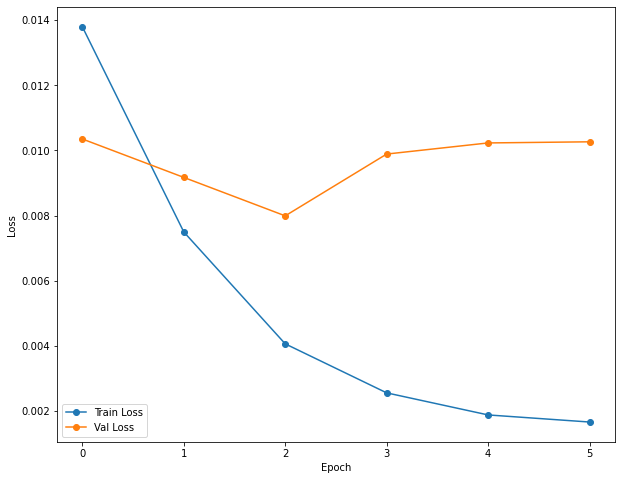

BERT+BiLSTM

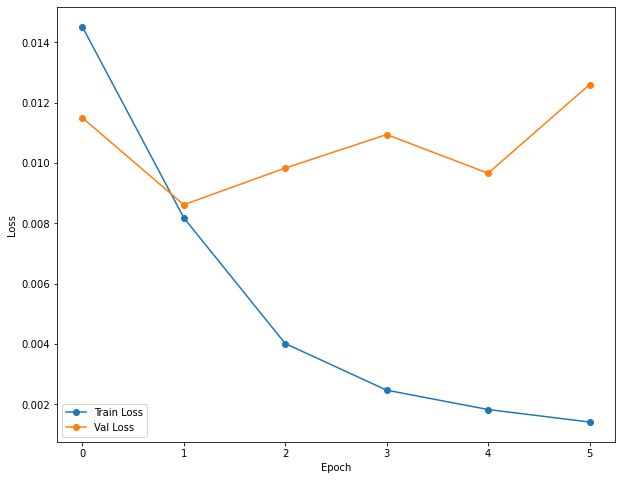

BERT+CNN

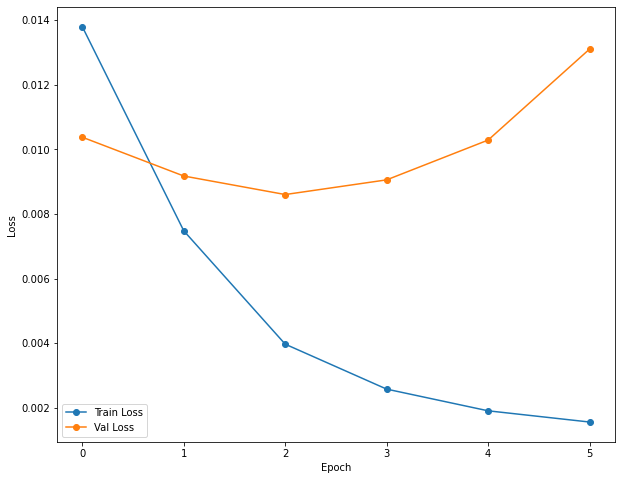

BERT

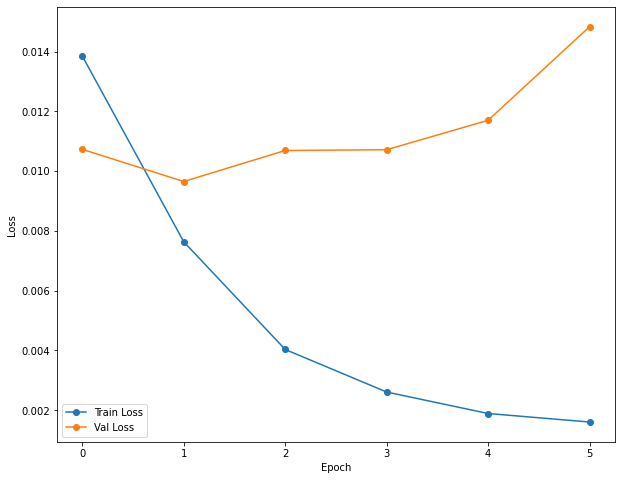

BERT+LSTM

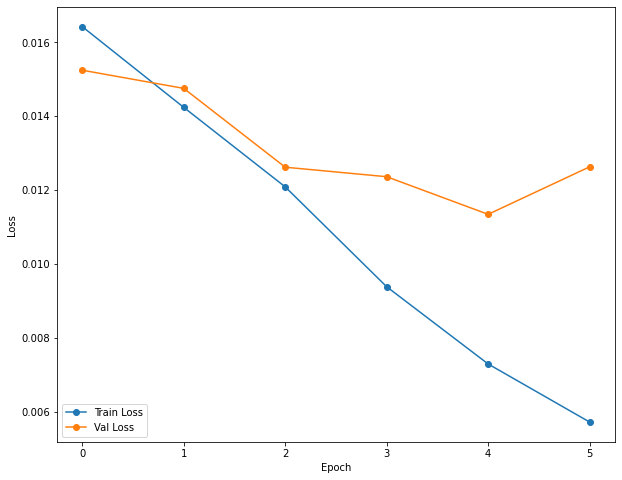

FastText+BiLSTM

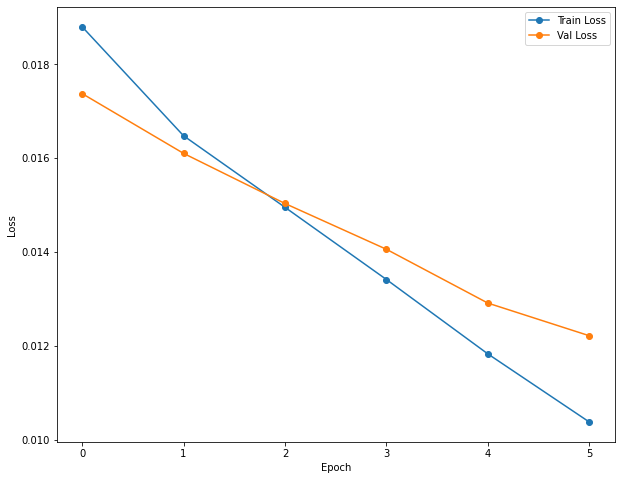

FastText+CNN

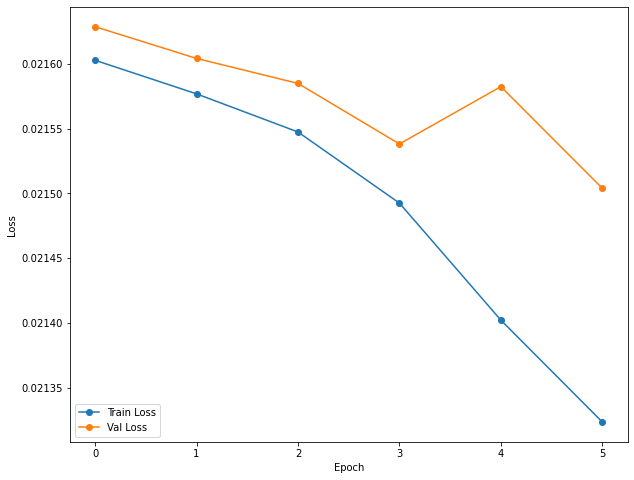

FastText+LSTM

#### Observation

As observed from the figures above, we got an overview about the learning curve (loss) against epochs on training and validation data.
  The x-axis represents the epoch number and the y-axis indicates the loss value. It is worth noting that for most of the models the training loss, which is the blue line, would decrease sharply for the first few epochs and then become slowly become smaller and smaller. Such a curve is much expected when training a model, but the models with FastText embeddings' training loss curve still decreases fast after the first few epochs and still demonstrated a downward trend at the end. Given more data maybe the training curve will finally slow down, and this might indicate that for our specific topic, FastText embedding requires more training data in order to gain better performance. As for the orange line, the validation loss, most of the models have validation loss increased near the end of the training, indicating potential overfitting after epochs except the FastText CNN model, which still has room of more training with more data.

Although the performance of FastText + LSTM is significantly behind other models, this occurs mainly because the model did not converge after the training phase had finished. However, in our previous effort in order to maximize each model's performance, we were able to get a test accuracy of around 0.87 across the quantitative metrics under hyper-parameter settings of epochs = 30, learning rate = 0.01, batch size = 64, and other settings the same as the ones in Table 2. Such performance is considered to be more than adequate for the model to qualify for the fake news detection task, and therefore this model combination still has potential even though it performs badly while other models have adequate scores under this setting.

For other models, we managed to get huge improvements compared with FastText + LSTM, and their balanced matrix indicates that their predictions are reliable with acceptable false positive and false negative results. Besides the worst-performing model of FastText + LSTM, our best-performing model is the BERT + CNN model, which has scores slightly higher than the BERT + BiLSTM model's scores.


In addition, The BERT coupled classifiers are all better than their FastText counterparts, and the gap between the worst-performing BERT model and the best-performing FastText model is still quite significant. Therefore, we can conclude that in our given hyper-parameter settings and datasets, the BERT embeddings yields better results than the FastText embeddings. It is also worth noticing that BERT + BiLSTM and BERT + CNN tend to perform slightly better than BERT + LSTM and FastText + BiLSTM and the vanilla BERT model as well.


# Analysis

# Limitations

# Conclusion